### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Embedding,Bidirectional,LSTM,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import words
from nltk.corpus import stopwords

import re
import os

### Data Preprocessing

In [2]:
df = pd.read_csv('../input/A_sentiment.csv')#,encoding='latin-1')

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
df.drop(['tweet_id','airline_sentiment_confidence','negativereason','negativereason_confidence','airline','airline_sentiment_gold','name','negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone'],axis=1,inplace=True)
df.rename(columns={"airline_sentiment": "Sentiment", "text": "Text"},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  14640 non-null  object
 1   Text       14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [5]:
df.head(10)

,Sentiment,Text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [7]:
text_list = []

for line in df.Text:  #From the text data, which are tweets, I am deleting all the words having '@' and 'http' characters because, those words are usernames , and website links and are waste data to the model.
        x = re.findall("[@]\w+", line)
        urls = re.findall('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%]+', line)
        X = x+urls
        y = line.split()
        resultwords = [word for word in y if word not in X]
        line = ' '.join(resultwords)
        text_list.append(line)
        
df.Text = text_list

In [8]:
stopwords = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would"]
sentences=[]                         #Preparing sentences list without stopwords, clean
labels = df.Sentiment.tolist()       #Labels are Sentiment column of the DataFrame
for line in text_list:               #text_list
        for word in stopwords:
            token = " "+word+" "
            line = line.replace(token, " ")
        sentences.append(line)

### NLP

In [9]:
#HyperParameters

embedding_dim = 100 
max_length = 175
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [10]:
max_length

175

In [11]:
#Getting training size

train_size = round(training_portion * len(sentences)) 

train_sentences = sentences[:train_size]
train_labels = np.array(labels[:train_size])

validation_sentences = sentences[train_size:]
validation_labels = np.array(labels[train_size:])

In [12]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# One hot encoding for training set
integer_encoded_train = train_labels.reshape(len(train_labels), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = validation_labels.reshape(len(validation_labels), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

In [13]:
print(onehot_encoder.categories_)

[array(['negative', 'neutral', 'positive'], dtype='<U8')]


In [14]:
vocab_size = len(set(" ".join(train_sentences).split()))
vocab_size

24135

In [15]:
#Tokenizing

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = np.array(pad_sequences(train_sequences,maxlen=max_length,truncating=trunc_type,padding=padding_type))

In [16]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = np.array(pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length))

print(len(validation_sequences))
print(validation_padded.shape)

2928
(2928, 175)


## Defining Model

In [17]:

model = tf.keras.Sequential([
    
    Embedding(vocab_size,embedding_dim,input_length = max_length),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    BatchNormalization(),
    Dropout(0.5),
    Flatten(),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 175, 100)          2413500   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [18]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=7e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
history = model.fit(train_padded,
                    onehot_encoded_train,
                    epochs=7,
                    validation_data=(validation_padded,onehot_encoded_val))

Epoch 1/7
366/366 [==============================] - 16s 44ms/step - loss: 1.1128 - accuracy: 0.4392 - val_loss: 0.9550 - val_accuracy: 0.7213
Epoch 2/7
366/366 [==============================] - 15s 41ms/step - loss: 0.9423 - accuracy: 0.5685 - val_loss: 0.7488 - val_accuracy: 0.7500
Epoch 3/7
366/366 [==============================] - 16s 42ms/step - loss: 0.8520 - accuracy: 0.6209 - val_loss: 0.6428 - val_accuracy: 0.7695
Epoch 4/7
366/366 [==============================] - 15s 41ms/step - loss: 0.7527 - accuracy: 0.6705 - val_loss: 0.5658 - val_accuracy: 0.7896
Epoch 5/7
366/366 [==============================] - 15s 41ms/step - loss: 0.6488 - accuracy: 0.7278 - val_loss: 0.6018 - val_accuracy: 0.7538
Epoch 6/7
366/366 [==============================] - 15s 42ms/step - loss: 0.5564 - accuracy: 0.7726 - val_loss: 0.5085 - val_accuracy: 0.8033
Epoch 7/7
366/366 [==============================] - 16s 43ms/step - loss: 0.4933 - accuracy: 0.8023 - val_loss: 0.5163 - val_accuracy: 0.8156

## Results

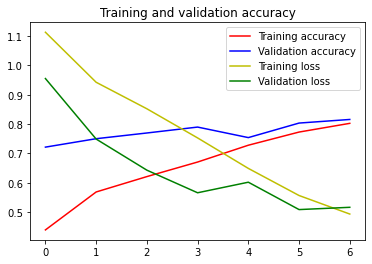

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [21]:
review = ["Air India made safe journey and provided timely healthy meal.",
        "This is the worst airline ever. Their on site agents give vague and unclear responses.",
        "I have flown several times with Air India. The staff is unbelievably rude, very disappointed",
        "Great experience, with a comfortable flight with better leg room than other private airlines while ticket price is competitive",
        "On board prices are too high",
        "The food was fine, but couldn't meet my expectations",
        "Well, I didn't love it before but now I do"]

review_clean = []
for line in review:             
        for word in stopwords:
            token = " "+word+" "
            line = line.replace(token, " ")
        review_clean.append(line)



a = tokenizer.texts_to_sequences(review_clean)
a1 = np.array(pad_sequences(a, maxlen = max_length, truncating = trunc_type, padding = padding_type))

## Predictions

In [22]:
predictions = model.predict(a1)
for i,p in enumerate(predictions):
    m = max(p)
    print(i+1,") ",review[i])
    if p.tolist().index(m) == 0:
        print("Negative")
    elif p.tolist().index(m) == 1:
        print("Neutral")
    else:
        print("Positive")
    print(" ")

1 )  Air India made safe journey and provided timely healthy meal.
Positive
 
2 )  This is the worst airline ever. Their on site agents give vague and unclear responses.
Negative
 
3 )  I have flown several times with Air India. The staff is unbelievably rude, very disappointed
Negative
 
4 )  Great experience, with a comfortable flight with better leg room than other private airlines while ticket price is competitive
Negative
 
5 )  On board prices are too high
Neutral
 
6 )  The food was fine, but couldn't meet my expectations
Negative
 
7 )  Well, I didn't love it before but now I do
Positive
 


As the model scored only 81% validation accuracy, it got the 4th prediction wrong, but overall I find it to work fine.